In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator

In [2]:
def read_datasets(path):
    df_chunk = pd.read_csv(path, chunksize=1000, header = None)
    
    chunk_list = []  # append each chunk df here 

    # Each chunk is in df format
    for chunk in df_chunk:  
        # perform data filtering 


        # Once the data filtering is done, append the chunk to list
        chunk_list.append(chunk)

    # concat the list into dataframe 
    info = pd.concat(chunk_list)
    return info

In [6]:
lis=[r'/raid/cs19btech11012/AnomalyDetection/UNSW15/UNSW-NB15-20220127T170817Z-001/UNSW-NB15/ANID/data/UNSW-NB15_1.csv'
     ,r'/raid/cs19btech11012/AnomalyDetection/UNSW15/UNSW-NB15-20220127T170817Z-001/UNSW-NB15/ANID/data/UNSW-NB15_2.csv',
     r'/raid/cs19btech11012/AnomalyDetection/UNSW15/UNSW-NB15-20220127T170817Z-001/UNSW-NB15/ANID/data/UNSW-NB15_3.csv',
     r'/raid/cs19btech11012/AnomalyDetection/UNSW15/UNSW-NB15-20220127T170817Z-001/UNSW-NB15/ANID/data/UNSW-NB15_4.csv']
df=pd.DataFrame()
for x in lis:
    df=pd.concat([df,read_datasets(x)])
    
df.reset_index(inplace = True)
df.drop('index',axis=1,inplace=True)

headers_df=pd.read_csv(r'/raid/cs19btech11012/AnomalyDetection/UNSW15/UNSW-NB15-20220127T170817Z-001/UNSW-NB15/ANID/data/NUSW-NB15_features.csv',encoding='cp1252')
headers_list=headers_df['Name'].to_list()
df.columns =headers_list

In [9]:
df['attack_cat'].unique()
df['attack_cat'] = df['attack_cat'].fillna('BENIGN')
df['attack_cat'].unique()

array(['BENIGN', 'Exploits', 'Reconnaissance', 'DoS', 'Generic',
       'Shellcode', ' Fuzzers', 'Worms', 'Backdoors', 'Analysis',
       ' Reconnaissance ', 'Backdoor', ' Fuzzers ', ' Shellcode '],
      dtype=object)

In [14]:
df

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,BENIGN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,BENIGN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,BENIGN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,BENIGN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,BENIGN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2540042,59.166.0.5,33094,149.171.126.7,43433,tcp,FIN,0.087306,320,1828,31,...,,1,2,3,3,1,1,3,BENIGN,0
2540043,59.166.0.7,20848,149.171.126.4,21,tcp,CON,0.365058,456,346,31,...,2,2,2,2,2,2,2,2,BENIGN,0
2540044,59.166.0.3,21511,149.171.126.9,21,tcp,CON,6.335154,1802,2088,31,...,2,2,2,4,2,2,2,2,BENIGN,0
2540045,59.166.0.9,35433,149.171.126.0,80,tcp,CON,2.200934,3498,166054,31,...,,1,1,2,4,2,2,2,BENIGN,0


In [20]:
def clean_data(data):
    
    data_label = data[["attack_cat"]].copy()
    
    data_trimed = data.iloc[:, : len(data.columns) -1 ].copy() #exclude the 'Label' columns
    
    data_trimed = data_trimed.apply(pd.to_numeric,errors='coerce')
    data_trimed = data_trimed.fillna(data_trimed.mean())
    data_trimed = data_trimed.fillna(0.0)
    data_label.loc[data_label['attack_cat'] == 'BENIGN' , "num_label"] = 0.0 #create new col "num_label" for numeric label
    data_label.loc[data_label['attack_cat'] != 'BENIGN' , "num_label"] = 1.0
    
    data_final = pd.concat([data_label['num_label'], data_trimed], axis = 1)
    data_final = data_final.round(5)
    
    return data_final

In [21]:
def feature_select(meta_train, meta_valid, correlation_mark = 0.2):

    meta = pd.concat([meta_train, meta_valid], axis = 0)
    meta = clean_data(meta)

    meta_corr = meta.corr(method='pearson').iloc[:, [0]]
    meta_corr = meta_corr.fillna(0)
    features  = list(meta_corr.index)[:] 


    fig, ax = plt.subplots(figsize = (100,5))

    plt.xticks(range(len(features)),  features, rotation=90)
    plt.plot(list(meta_corr.iloc[:,0]))
    plt.xlabel('features', fontsize = 15)
    plt.ylabel('PCC Score', fontsize = 15)
    ax.axhline(y=correlation_mark, linestyle = ":", color = 'r')
    ax.axhline(y= 0.0, linestyle = ":", color = 'r')
    ax.axhline(y= -correlation_mark, linestyle = ":", color = 'r')
    ax.set_ylim(-0.5, 0.5)
    plt.show()


    ############## feature selection #################
    feature_select_dict = dict()
    features_select = []
    for i in range(len(list(meta_corr.iloc[:,0]))):
        if abs(list(meta_corr.iloc[:,0])[i]) >= correlation_mark:
            feature_select_dict[features[i]] = list(meta_corr.iloc[:,0])[i]
            features_select.append(features[i])

    print ('number of features: {}'.format(len(features_select)))
    print ('\n')
    print (' Selected features for model: ', features_select)
    meta_train = clean_data(meta_train)
    meta_valid = clean_data(meta_valid)

    meta_train_select = meta_train[features_select]
    meta_valid_select = meta_valid[features_select]

    return meta_train_select, meta_valid_select, features_select, feature_select_dict

In [22]:
all_train_reduced=df.iloc[:1524028,:]
all_test_reduced=df.iloc[1524028:2032037,:]
all_valid_reduced=df.iloc[2032037:,:]

In [23]:
print (all_train_reduced.groupby(['attack_cat']).size().reset_index(name='counts'))
print (all_valid_reduced.groupby(['attack_cat']).size().reset_index(name='counts'))
print (all_test_reduced.groupby(['attack_cat']).size().reset_index(name='counts'))

          attack_cat   counts
0            Fuzzers     5051
1           Fuzzers      5861
2    Reconnaissance      3802
3         Shellcode       402
4           Analysis     1218
5             BENIGN  1415027
6           Backdoor      405
7          Backdoors      534
8                DoS     6091
9           Exploits    18102
10           Generic    65483
11    Reconnaissance     1759
12         Shellcode      223
13             Worms       70
         attack_cat  counts
0          Fuzzers     6713
1   Reconnaissance     4064
2        Shellcode      440
3          Analysis     678
4            BENIGN  408911
5          Backdoor     702
6               DoS    5161
7          Exploits   12851
8           Generic   68438
9             Worms      52
         attack_cat  counts
0          Fuzzers     6621
1   Reconnaissance     4362
2        Shellcode      446
3          Analysis     781
4            BENIGN  394826
5          Backdoor     688
6               DoS    5101
7          Exploit

In [26]:
all_attack = 5051 + 5861 + 3802 + 402 + 1218 + 405 + 534+6091+18102+65483+1759+223+70+   6713+4064+440+678+702+5161+12851+63438+52+ 6621+4362+44+781+688+5101+13572+81560+52
non_attack = 1415027 + 408911 + 394826

print (all_attack / (all_attack + non_attack))
print (all_attack + non_attack)

0.12462534201041961
2534645


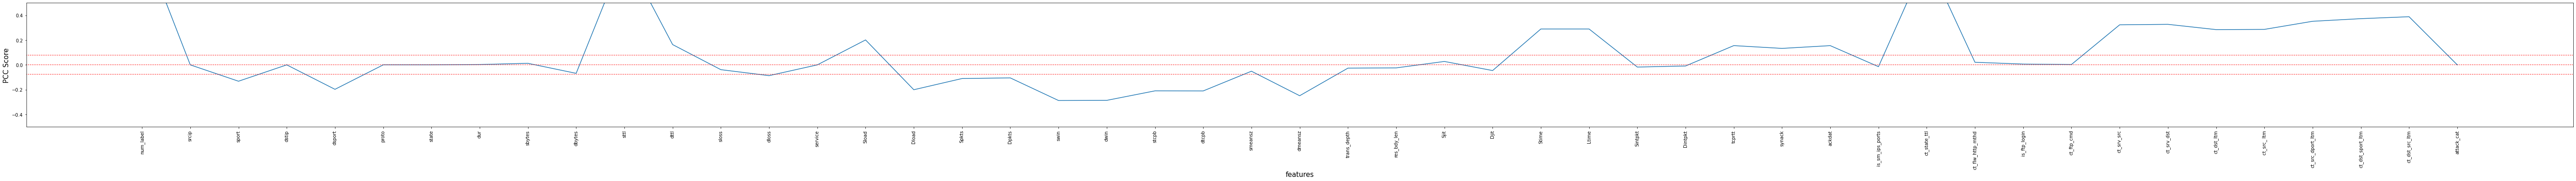

number of features: 28


 Selected features for model:  ['num_label', 'sport', 'dsport', 'sttl', 'dttl', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'dmeansz', 'Stime', 'Ltime', 'tcprtt', 'synack', 'ackdat', 'ct_state_ttl', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm']


In [27]:
##****** Features used for the 1% attack datasets

threshold = 0.078 #select features with PCC score greater or equals to threshold 
alltrainreduced_select, allvalidreduced_select, features_select, fea_dict = feature_select(all_train_reduced, all_valid_reduced, correlation_mark = threshold)
alltestreduced_select = clean_data(all_test_reduced)[features_select]

In [28]:
fea_dict_d = sorted(fea_dict.items(), key=operator.itemgetter(1))
fea_dict_d # Features and its PCC score sorted

[('swin', -0.2875704485618286),
 ('dwin', -0.28645669850717814),
 ('dmeansz', -0.24903499813817428),
 ('dtcpb', -0.21036520752268772),
 ('stcpb', -0.20979974426156786),
 ('Dload', -0.20067934292767958),
 ('dsport', -0.19734351903112576),
 ('sport', -0.1319878551997),
 ('Spkts', -0.11034961584753851),
 ('Dpkts', -0.10507648005436207),
 ('dloss', -0.0868866348487135),
 ('synack', 0.13292920590786322),
 ('ackdat', 0.15521859867499518),
 ('tcprtt', 0.15538555109252575),
 ('dttl', 0.1637583789737894),
 ('Sload', 0.20121808628145577),
 ('ct_dst_ltm', 0.28450198813052796),
 ('ct_src_ ltm', 0.2862918519024169),
 ('Stime', 0.28956440011017176),
 ('Ltime', 0.28956444736581194),
 ('ct_srv_src', 0.3232214151413415),
 ('ct_srv_dst', 0.3270644423298762),
 ('ct_src_dport_ltm', 0.3516318262441765),
 ('ct_dst_sport_ltm', 0.37289038237597416),
 ('ct_dst_src_ltm', 0.38851336971832723),
 ('ct_state_ttl', 0.860429470290557),
 ('sttl', 0.900256782362455),
 ('num_label', 1.0)]